# **Emotion Detection Using MobileNetV2**

**Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

**Load Training and Validation Data**

In [2]:
image_path="/content/drive/MyDrive/images/train"

train_path="/content/drive/MyDrive/images/train"
valid_path="/content/drive/MyDrive/images/validation"

In [3]:
# Define the list of class names (folders)
class_names = [folder for folder in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, folder))]

In [4]:
class_names

['neutral', 'surprise', 'sad', 'angry', 'happy', 'fear', 'disgust']

In [5]:
number_of_images = {}
for class_name in class_names:
    number_of_images[class_name] = len(os.listdir(image_path+"/"+class_name))

images_per_class = pd.DataFrame(list(number_of_images.items()), columns=['Class Name', 'Number of Images'])
images_per_class

,Class Name,Number of Images
0,neutral,4982
1,surprise,3205
2,sad,4938
3,angry,3993
4,happy,7164
5,fear,4103
6,disgust,436


In [6]:
# Training data generator with data augmentation
traindata_generator = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (rescaling only)
validdata_generator = ImageDataGenerator(rescale=1./255)

In [7]:
# Training data
train_generator = traindata_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Validation data
validation_generator = validdata_generator.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**Load MobileNetV2 Model**

In [8]:
# Load MobileNetV2 with pre-trained weights and exclude the top layers
mobilenetV2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Modify MobileNetV2 Model Architecture**

In [9]:
# Freeze the base model
for layer in mobilenetV2_model.layers:
    layer.trainable = False

# Adding custom layers on top of the base model
x = mobilenetV2_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
prediction = Dense(7, activation='softmax')(x)

In [10]:
# Create the final model
model = Model(inputs=mobilenetV2_model.input, outputs=prediction)

**Compile Model**

In [11]:
# Compile the model
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,100,167 (15.64 MB)

 Trainable params: 1,841,159 (7.02 MB)

 Non-trainable params: 2,259,008 (8.62 MB)

**Train Model**

In [13]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [14]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 8228s 9s/step - accuracy: 0.3481 - loss: 1.7816 - val_accuracy: 0.3578 - val_loss: 2.6944 - learning_rate: 0.0010
Epoch 2/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 357s 393ms/step - accuracy: 0.4093 - loss: 1.5395 - val_accuracy: 0.3142 - val_loss: 2.0486 - learning_rate: 0.0010
Epoch 3/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 357s 393ms/step - accuracy: 0.4216 - loss: 1.4958 - val_accuracy: 0.4505 - val_loss: 1.4420 - learning_rate: 0.0010
Epoch 4/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 359s 396ms/step - accuracy: 0.4398 - loss: 1.4665 - val_accuracy: 0.4437 - val_loss: 1.4939 - learning_rate: 0.0010
Epoch 5/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 357s 393ms/step - accuracy: 0.4340 - loss: 1.4595 - val_accuracy: 0.0294 - val_loss: 4.6994 - learning_rate: 0.0010
Epoch 6/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 358s 394ms/step - accuracy: 0.4423 - loss: 1.4521 - val_accuracy: 0.4321 - val_loss: 1.4691 - learning_rate: 0.0010
Epoch 7/20
901/901 ━━━━━━━━━━━━━━━━━━━━ 356s 393ms/step - accuracy: 0.4561 - 

**Fine-Tune MobileNetV2 Model**

In [15]:
# Unfreeze the base model and fine-tune
for layer in mobilenetV2_model.layers:
    layer.trainable = True

In [16]:
# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

**Train Fine-Tuned Model**

In [17]:
# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 432s 424ms/step - accuracy: 0.3038 - loss: 1.8290 - val_accuracy: 0.4215 - val_loss: 1.5434 - learning_rate: 1.0000e-05
Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 358s 394ms/step - accuracy: 0.4290 - loss: 1.4902 - val_accuracy: 0.4292 - val_loss: 1.4886 - learning_rate: 1.0000e-05
Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 359s 396ms/step - accuracy: 0.4725 - loss: 1.3736 - val_accuracy: 0.4509 - val_loss: 1.4285 - learning_rate: 1.0000e-05
Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 359s 395ms/step - accuracy: 0.4977 - loss: 1.3088 - val_accuracy: 0.4578 - val_loss: 1.3994 - learning_rate: 1.0000e-05
Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 359s 396ms/step - accuracy: 0.5253 - loss: 1.2441 - val_accuracy: 0.4815 - val_loss: 1.3620 - learning_rate: 1.0000e-05


**Plot Training and Validation Loss**

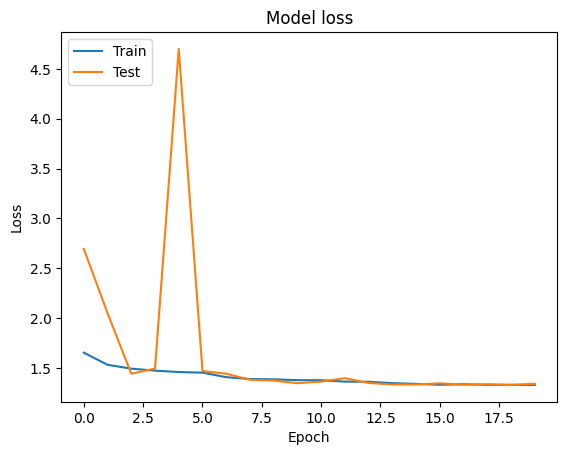

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Plot Training and Validation Accuracy**

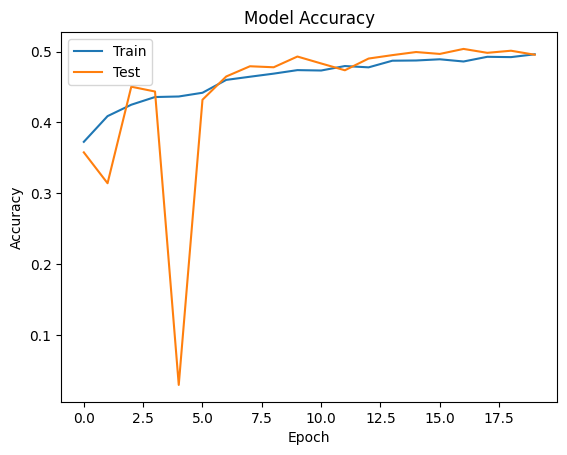

In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Generate Confusion Matrix**

In [20]:
true_classes = validation_generator.classes
predicted_classes = np.argmax(model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / validation_generator.batch_size))), axis=1)
class_labels = list(validation_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

221/221 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step


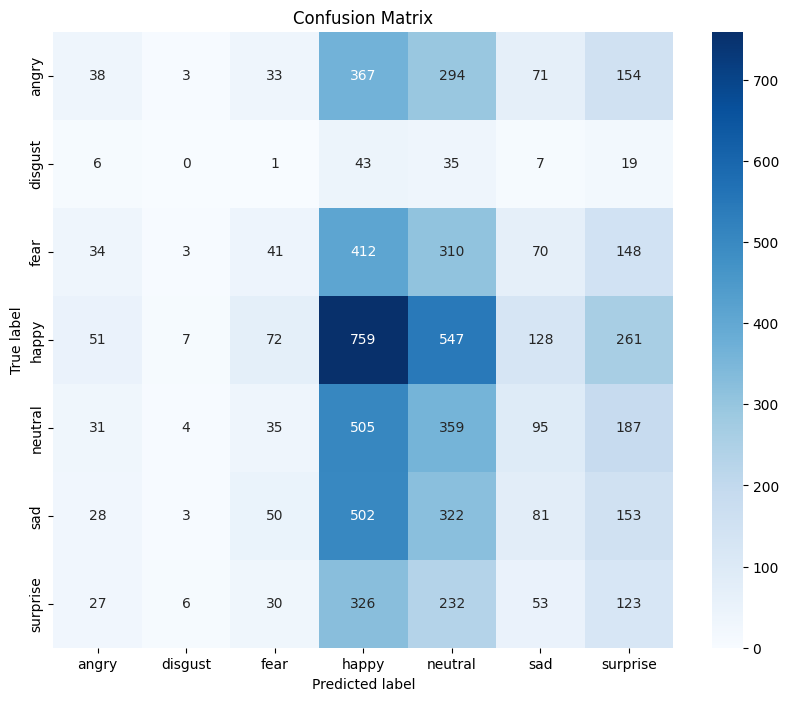

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Display Classification Report**

In [22]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.18      0.04      0.06       960
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.04      0.06      1018
       happy       0.26      0.42      0.32      1825
     neutral       0.17      0.30      0.22      1216
         sad       0.16      0.07      0.10      1139
    surprise       0.12      0.15      0.13       797

    accuracy                           0.20      7066
   macro avg       0.15      0.15      0.13      7066
weighted avg       0.18      0.20      0.17      7066



**Save Model**

In [23]:
model.save('emotion_detection_model.h5')